# Lecture 4: Many more complicated data things

- logarithms review

- bivariate summary statistics, and groupby.apply

- joining data frames

- melting/pivoting long-to-wide and wide-to-long

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gapminder = pd.read_csv('../datasets/gapminder.csv')
# download here:
# https://raw.githubusercontent.com/UCSD-CSS-001/ucsd-css-001.github.io/main/datasets/gapminder.csv

gapminder = gapminder.drop(columns = ['Unnamed: 0'])

In [3]:
gapminder

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106
...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623


## Summary statistics

### the wonders of logarithms.  

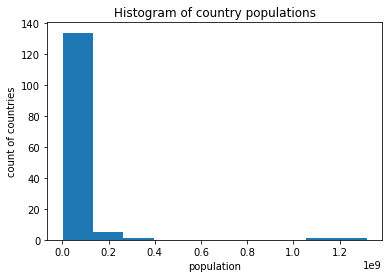

In [4]:
f = plt.hist(gapminder[gapminder['year']==2007]['pop'])
f = plt.xlabel('population')
f = plt.ylabel('count of countries')
f = plt.title('Histogram of country populations')

In [5]:
gapminder[gapminder['year']==2007]['pop'].median()

10517531.0

Yikes!  Most standard statistics do not work well with data like this.  Standard statistics are designed for roughly normal (i.e., gaussian, bell-shaped) distributions.   

Fortunately, lots of variables, like population, wealth, income, gdp, etc. are roughly log-normally distributed.  Meaning their *logarithm* is normal.

So we can do standard statistics with them after log-transforming

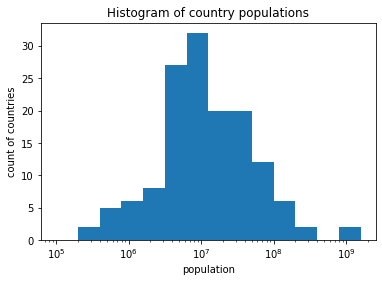

In [6]:
freq, bins, _ = plt.hist(gapminder[gapminder['year']==2007]['pop'],
                        bins = np.logspace(5, 9.2, num=15, base=10))
f = plt.xlabel('population')
f = plt.ylabel('count of countries')
f = plt.title('Histogram of country populations')
f = plt.xscale('log')

In [7]:
np.logspace(5, 9, num=10, base=10)

array([1.00000000e+05, 2.78255940e+05, 7.74263683e+05, 2.15443469e+06,
       5.99484250e+06, 1.66810054e+07, 4.64158883e+07, 1.29154967e+08,
       3.59381366e+08, 1.00000000e+09])

### mean, median, mode, stdev, var, etc.

In [8]:
populations_in_2007 = gapminder[gapminder['year']==2007]['pop']


In [9]:
print(populations_in_2007.mean()) # sum / count
print(populations_in_2007.median()) # number such that 50% are higher and 50% are lower

44021219.57042254
10517531.0


In [10]:
print(populations_in_2007.mode()) # does not make sense for numbers.

0          199579
1          301931
2          496374
3          551201
4          684736
          ...    
137     190010647
138     223547000
139     301139947
140    1110396331
141    1318683096
Length: 142, dtype: int64


In [11]:
gapminder['continent'].mode() # makes sense for categorical

0    Africa
dtype: object

In [12]:
populations_in_2007.std()

147621397.90361592

In [13]:
populations_in_2007.var()**(1/2)

147621397.90361592

#### weighted statistcs

In [14]:
populations_in_2007.mean()

44021219.57042254

In [15]:
def custom_mean(nparray):
    return sum(nparray)/len(nparray)

In [16]:
custom_mean(populations_in_2007)

44021219.57042254

In [17]:
gm_2007 = gapminder[gapminder['year']==2007]
gm_2007

,country,continent,year,lifeExp,pop,gdpPercap
11,Afghanistan,Asia,2007,43.828,31889923,974.580338
23,Albania,Europe,2007,76.423,3600523,5937.029526
35,Algeria,Africa,2007,72.301,33333216,6223.367465
47,Angola,Africa,2007,42.731,12420476,4797.231267
59,Argentina,Americas,2007,75.320,40301927,12779.379640
...,...,...,...,...,...,...
1655,Vietnam,Asia,2007,74.249,85262356,2441.576404
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798
1679,"Yemen, Rep.",Asia,2007,62.698,22211743,2280.769906
1691,Zambia,Africa,2007,42.384,11746035,1271.211593


In [18]:
gm_2007['gdpPercap'].mean()

11680.071819878172

In [19]:
x = [1, 2, 3, 4]
print(len(x))
print(sum([1, 1, 1, 1]))

4
4


In [20]:
def weighted_mean(values, weights):
    # works for numpy arrays.
    return sum(values * weights) / sum(weights)

In [21]:
x = [1, 2, 3, 4]
w = [1, 1, 1, 10]
# sum: 46 / denominator: 13
# [1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
weighted_mean(np.array(x), np.array(w))

3.5384615384615383

In [22]:
# not the same
x = [1, 2, 3, 40]
w = [1, 1, 1, 1]
# sum = 46 denominator: 4
weighted_mean(np.array(x), np.array(w))

11.5

In [23]:
# population-weighted average of gdp per capita
weighted_mean(gm_2007['gdpPercap'], gm_2007['pop'])

9295.986594480439

### bivariate statistics

consider life expectancy ~ gdp per capita

In [24]:
gm_2007

,country,continent,year,lifeExp,pop,gdpPercap
11,Afghanistan,Asia,2007,43.828,31889923,974.580338
23,Albania,Europe,2007,76.423,3600523,5937.029526
35,Algeria,Africa,2007,72.301,33333216,6223.367465
47,Angola,Africa,2007,42.731,12420476,4797.231267
59,Argentina,Americas,2007,75.320,40301927,12779.379640
...,...,...,...,...,...,...
1655,Vietnam,Asia,2007,74.249,85262356,2441.576404
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798
1679,"Yemen, Rep.",Asia,2007,62.698,22211743,2280.769906
1691,Zambia,Africa,2007,42.384,11746035,1271.211593


Text(0, 0.5, 'life expectancy in 2007')

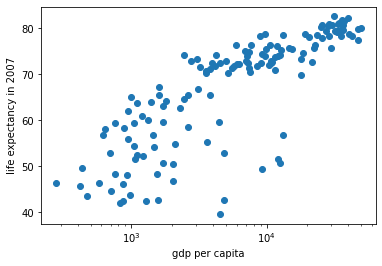

In [25]:
plt.scatter(gm_2007['gdpPercap'], gm_2007['lifeExp'])
plt.xscale('log')
plt.xlabel('gdp per capita')
plt.ylabel('life expectancy in 2007')

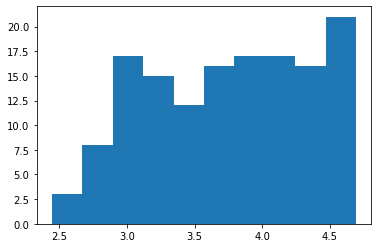

In [26]:
# why we are log transforming gdp
f = plt.hist(np.log10(gm_2007['gdpPercap']))

#### correlation

we want to calculate the correlation between log10(gdpPercap) and life Exp

In [27]:
def cor(x,y):
    mx = x.mean()
    my = y.mean()
    sx = x.std()
    sy = y.std()
    zx = (x-mx)/sx
    zy = (y-my)/sy
    return (zx*zy).sum() / (len(zx)-1)

In [28]:
cor(np.log10(gm_2007['gdpPercap']), gm_2007['lifeExp'])

0.8089802514849214

In [29]:
x = np.log10(gm_2007['gdpPercap'])
y = gm_2007['lifeExp']
np.corrcoef(x, y)[0,1]

0.8089802514849209

In [30]:
gm_2007['lifeExp'].corr(np.log10(gm_2007['gdpPercap']))

0.808980251484921

In [31]:
# r^2, coefficient of determination, 
gm_2007['lifeExp'].corr(np.log10(gm_2007['gdpPercap']))**2

0.6544490472926061

#### regression line

In [32]:
x = np.log10(gm_2007['gdpPercap'])
y = gm_2007['lifeExp']
fit = np.polyfit(x,y,1)
slope = fit[0]
intercept = fit[1]
print(f'{slope=}, {intercept=}')

slope=16.58506352520344, intercept=4.949611651060741


In [33]:
np.corrcoef(x, y)[0,1]

0.8089802514849209

In [34]:
# predictions from our fitted line
new_x = np.linspace(2, 5.2, 10)
predicted_y = new_x*slope + intercept

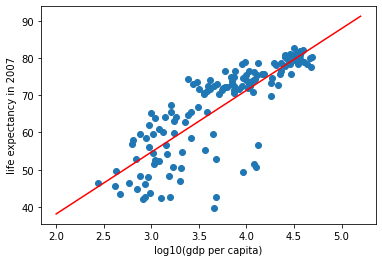

In [35]:
plt.scatter(x, y)
plt.xlabel('log10(gdp per capita)')
plt.ylabel('life expectancy in 2007')
plt.plot(new_x, predicted_y,'r-')

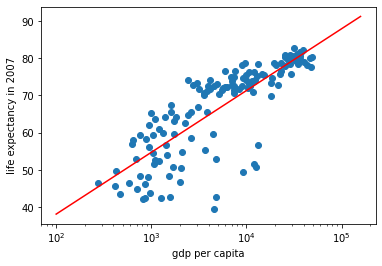

In [36]:
plt.scatter(gm_2007['gdpPercap'], gm_2007['lifeExp'])
plt.xscale('log')
plt.xlabel('gdp per capita')
plt.ylabel('life expectancy in 2007')
plt.plot(10**new_x, predicted_y, 'r-')

# log10 gdp per cap

## Advanced summarization via groupby.apply

consider life expectancy ~ gdp per capita by continent (by year)

In [37]:
gapminder

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106
...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623


In [38]:
# calculate correlation of log10(gdpPercap) and lifeExp for each year

gapminder.groupby('year').agg(mean_life = ('lifeExp', 'mean'))


,mean_life
year,
1952,49.057620
1957,51.507401
1962,53.609249
1967,55.678290
1972,57.647386
1977,59.570157
1982,61.533197
1987,63.212613
1992,64.160338


In [39]:
def summary_function(df):
    return np.corrcoef(np.log10(df['gdpPercap']), df['lifeExp'])[0,1]

for grp_name, grp_df in gapminder.groupby('year'):
    print(grp_name, summary_function(grp_df))


1952 0.7477807347946165
1957 0.758795706016415
1962 0.7705225443103859
1967 0.7729986641186484
1972 0.789405727501936
1977 0.8135258808158442
1982 0.846073426279085
1987 0.8743940682796121
1992 0.8558149463091763
1997 0.8640205504436029
2002 0.8251326766424232
2007 0.8089802514849209


In [40]:
gapminder.groupby('year').apply(summary_function)

year
1952    0.747781
1957    0.758796
1962    0.770523
1967    0.772999
1972    0.789406
1977    0.813526
1982    0.846073
1987    0.874394
1992    0.855815
1997    0.864021
2002    0.825133
2007    0.808980
dtype: float64

In [41]:
def summary_function(df):
    r = np.corrcoef(np.log10(df['gdpPercap']), df['lifeExp'])[0,1]
    fit = np.polyfit(np.log10(df['gdpPercap']),df['lifeExp'],1)
    slope = fit[0]
    intercept = fit[1]
    return pd.Series({'correlation':r,
                      'slope': slope})

In [42]:
summary_function(gapminder)

correlation     0.807618
slope          19.353423
dtype: float64

In [43]:
gapminder.groupby('year').apply(summary_function)

,correlation,slope
year,,
1952,0.747781,20.331397
1957,0.758796,20.102944
1962,0.770523,19.797228
1967,0.772999,18.535251
1972,0.789406,17.493729
1977,0.813526,17.382310
1982,0.846073,17.254635
1987,0.874394,16.966816
1992,0.855815,17.327658


## Joining data frames.

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#database-style-dataframe-or-named-series-joining-merging

- inner, outer, left, right

In [44]:
instructors = pd.DataFrame({'name':['Ed Vul', 'Drew Walker', 'Shannon Ellis', 'Erik Brockbank', 'Judy Fan'],
                            'email': ['evul@ucsd.edu','drew@fake.com', 'shannon@fake.com', 'erik@fake.com', 'judy@fake.com'],
                            'location': ['McGill 5137', 'COGS 563', 'COGS 123', 'Mandler 3509', 'McGill 5139?']})

classes = pd.DataFrame({'name':['CSS 1', 'CSS 2', 'COGS 18', 'PSYC 201', 'PSYC 60', 'COGS 9', 'PSYC 100'],
                        'location': ['mandler', 'mcgill', 'cog sci', 'mcgill', 'peterson', 'cog sci', 'auditorium'],
                       'instructor_name':['Ed Vul', 'Ed Vul', 'Shannon Ellis', 'Ed Vul', 'Judy Fan', 'Drew Walker', 'John Serences']})


In [45]:
instructors

,name,email,location
0,Ed Vul,evul@ucsd.edu,McGill 5137
1,Drew Walker,drew@fake.com,COGS 563
2,Shannon Ellis,shannon@fake.com,COGS 123
3,Erik Brockbank,erik@fake.com,Mandler 3509
4,Judy Fan,judy@fake.com,McGill 5139?


In [46]:
classes

,name,location,instructor_name
0,CSS 1,mandler,Ed Vul
1,CSS 2,mcgill,Ed Vul
2,COGS 18,cog sci,Shannon Ellis
3,PSYC 201,mcgill,Ed Vul
4,PSYC 60,peterson,Judy Fan
5,COGS 9,cog sci,Drew Walker
6,PSYC 100,auditorium,John Serences


In [47]:
pd.merge(instructors, 
         classes, 
         # either one 'on'
         left_on = 'name', 
         right_on='instructor_name', 
         how='inner', 
         suffixes=['_prof', '_class'])

,name_prof,email,location_prof,name_class,location_class,instructor_name
0,Ed Vul,evul@ucsd.edu,McGill 5137,CSS 1,mandler,Ed Vul
1,Ed Vul,evul@ucsd.edu,McGill 5137,CSS 2,mcgill,Ed Vul
2,Ed Vul,evul@ucsd.edu,McGill 5137,PSYC 201,mcgill,Ed Vul
3,Drew Walker,drew@fake.com,COGS 563,COGS 9,cog sci,Drew Walker
4,Shannon Ellis,shannon@fake.com,COGS 123,COGS 18,cog sci,Shannon Ellis
5,Judy Fan,judy@fake.com,McGill 5139?,PSYC 60,peterson,Judy Fan


In [48]:
instructors = pd.DataFrame({'instructor_name':['Ed Vul', 'Drew Walker', 'Shannon Ellis', 'Erik Brockbank', 'Judy Fan'],
                            'email': ['evul@ucsd.edu','drew@fake.com', 'shannon@fake.com', 'erik@fake.com', 'judy@fake.com'],
                            'office': ['McGill 5137', 'COGS 563', 'COGS 123', 'Mandler 3509', 'McGill 5139?']})

classes = pd.DataFrame({'class_name':['CSS 1', 'CSS 2', 'COGS 18', 'PSYC 201', 'PSYC 60', 'COGS 9', 'PSYC 100'],
                        'location': ['mandler', 'mcgill', 'cog sci', 'mcgill', 'peterson', 'cog sci', 'auditorium'],
                       'instructor_name':['Ed Vul', 'Ed Vul', 'Shannon Ellis', 'Ed Vul', 'Judy Fan', 'Drew Walker', 'John Serences']})


In [49]:
instructors

,instructor_name,email,office
0,Ed Vul,evul@ucsd.edu,McGill 5137
1,Drew Walker,drew@fake.com,COGS 563
2,Shannon Ellis,shannon@fake.com,COGS 123
3,Erik Brockbank,erik@fake.com,Mandler 3509
4,Judy Fan,judy@fake.com,McGill 5139?


In [50]:
classes

,class_name,location,instructor_name
0,CSS 1,mandler,Ed Vul
1,CSS 2,mcgill,Ed Vul
2,COGS 18,cog sci,Shannon Ellis
3,PSYC 201,mcgill,Ed Vul
4,PSYC 60,peterson,Judy Fan
5,COGS 9,cog sci,Drew Walker
6,PSYC 100,auditorium,John Serences


In [51]:
pd.merge(classes, 
         instructors, 
         on='instructor_name',
         how='inner')

,class_name,location,instructor_name,email,office
0,CSS 1,mandler,Ed Vul,evul@ucsd.edu,McGill 5137
1,CSS 2,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
2,PSYC 201,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
3,COGS 18,cog sci,Shannon Ellis,shannon@fake.com,COGS 123
4,PSYC 60,peterson,Judy Fan,judy@fake.com,McGill 5139?
5,COGS 9,cog sci,Drew Walker,drew@fake.com,COGS 563


In [52]:
pd.merge(classes, 
         instructors, 
         on='instructor_name',
         how='left')

,class_name,location,instructor_name,email,office
0,CSS 1,mandler,Ed Vul,evul@ucsd.edu,McGill 5137
1,CSS 2,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
2,COGS 18,cog sci,Shannon Ellis,shannon@fake.com,COGS 123
3,PSYC 201,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
4,PSYC 60,peterson,Judy Fan,judy@fake.com,McGill 5139?
5,COGS 9,cog sci,Drew Walker,drew@fake.com,COGS 563
6,PSYC 100,auditorium,John Serences,NaN,NaN


In [53]:
pd.merge(classes, 
         instructors, 
         on='instructor_name',
         how='right')

,class_name,location,instructor_name,email,office
0,CSS 1,mandler,Ed Vul,evul@ucsd.edu,McGill 5137
1,CSS 2,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
2,PSYC 201,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
3,COGS 9,cog sci,Drew Walker,drew@fake.com,COGS 563
4,COGS 18,cog sci,Shannon Ellis,shannon@fake.com,COGS 123
5,NaN,NaN,Erik Brockbank,erik@fake.com,Mandler 3509
6,PSYC 60,peterson,Judy Fan,judy@fake.com,McGill 5139?


In [54]:
pd.merge(classes, 
         instructors, 
         on='instructor_name',
         how='outer')

,class_name,location,instructor_name,email,office
0,CSS 1,mandler,Ed Vul,evul@ucsd.edu,McGill 5137
1,CSS 2,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
2,PSYC 201,mcgill,Ed Vul,evul@ucsd.edu,McGill 5137
3,COGS 18,cog sci,Shannon Ellis,shannon@fake.com,COGS 123
4,PSYC 60,peterson,Judy Fan,judy@fake.com,McGill 5139?
5,COGS 9,cog sci,Drew Walker,drew@fake.com,COGS 563
6,PSYC 100,auditorium,John Serences,NaN,NaN
7,NaN,NaN,Erik Brockbank,erik@fake.com,Mandler 3509


## Reshaping / pivoting / tidy / long-wide transforms

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-by-melt

### Wide data

![wide](lotr-wide.png)

### Long data

![long](lotr-long.png)



back to gapminder

In [55]:
gapminder

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106
...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623


### long to wide

- unstack (via index)

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-by-stacking-and-unstacking

- pivot (via column names)

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-by-pivoting-dataframe-objects

- need to deal with multi-index

https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#


**Goal**: See how mean life expectancy in Europe and Asia has changed over the years.  

**Output:** A scatterplot over time, with x: mean life expectancy in europe, and y: mean life expectnacy in Asia, and each data point is a year.

**Process:**

- group by continent and year, and calculate mean life expectancy

- convert long to wide format, with one column per continent



In [56]:
summary_data = (gapminder
   .groupby(['continent', 'year'])
   .agg(m_lifeExp = ('lifeExp', 'mean'),
        s_lifeExp = ('lifeExp', 'std')))
summary_data

m_lifeExp  s_lifeExp
continent year                      
Africa    1952  39.135500   5.151581
          1957  41.266346   5.620123
          1962  43.319442   5.875364
          1967  45.334538   6.082673
          1972  47.450942   6.416258
          1977  49.580423   6.808197
          1982  51.592865   7.375940
          1987  53.344788   7.864089
          1992  53.629577   9.461071
          1997  53.598269   9.103387
          2002  53.325231   9.586496
          2007  54.806038   9.630781
Americas  1952  53.279840   9.326082
          1957  55.960280   9.033192
          1962  58.398760   8.503544
          1967  60.410920   7.909171
          1972  62.394920   7.323017
          1977  64.391560   7.069496
          1982  66.228840   6.720834
          1987  68.090720   5.801929
          1992  69.568360   5.167104
          1997  71.150480   4.887584
          2002  72.422040   4.799705
          2007  73.608120   4.440948
Asia      1952  46.314394   9.291751
          1957  49.318544   9.635429
          1962  51.563223   9.820632
          1967  54.663640   9.650965
          1972  57.319269   9.722700
          1977  59.610556  10.022197
          1982  62.617939   8.535221
          1987  64.851182   8.203792
          1992  66.537212   8.075549
          1997  68.020515   8.091171
          2002  69.233879   8.374595
          2007  70.728485   7.963724
Europe    1952  64.408500   6.361088
          1957  66.703067   5.295805
          1962  68.539233   4.302500
          1967  69.737600   3.799728
          1972  70.775033   3.240576
          1977  71.937767   3.121030
          1982  72.806400   3.218260
          1987  73.642167   3.169680
          1992  74.440100   3.209781
          1997  75.505167   3.104677
          2002  76.700600   2.922180
          2007  77.648600   2.979813
Oceania   1952  69.255000   0.190919
          1957  70.295000   0.049497
          1962  71.085000   0.219203
          1967  71.310000   0.296985
          1972  71.910000   0.028284
          1977  72.855000   0.898026
          1982  74.290000   0.636396
          1987  75.320000   1.414214
          1992  76.945000   0.869741
          1997  78.190000   0.905097
          2002  79.740000   0.890955
          2007  80.719500   0.729027

In [57]:
# via unstacking by index
summary_data.unstack('continent')

m_lifeExp                                          s_lifeExp  \
continent     Africa  Americas       Asia     Europe  Oceania    Africa   
year                                                                      
1952       39.135500  53.27984  46.314394  64.408500  69.2550  5.151581   
1957       41.266346  55.96028  49.318544  66.703067  70.2950  5.620123   
1962       43.319442  58.39876  51.563223  68.539233  71.0850  5.875364   
1967       45.334538  60.41092  54.663640  69.737600  71.3100  6.082673   
1972       47.450942  62.39492  57.319269  70.775033  71.9100  6.416258   
1977       49.580423  64.39156  59.610556  71.937767  72.8550  6.808197   
1982       51.592865  66.22884  62.617939  72.806400  74.2900  7.375940   
1987       53.344788  68.09072  64.851182  73.642167  75.3200  7.864089   
1992       53.629577  69.56836  66.537212  74.440100  76.9450  9.461071   
1997       53.598269  71.15048  68.020515  75.505167  78.1900  9.103387   
2002       53.325231  72.42204  69.233879  76.700600  79.7400  9.586496   
2007       54.806038  73.60812  70.728485  77.648600  80.7195  9.630781   

                                                    
continent  Americas       Asia    Europe   Oceania  
year                                                
1952       9.326082   9.291751  6.361088  0.190919  
1957       9.033192   9.635429  5.295805  0.049497  
1962       8.503544   9.820632  4.302500  0.219203  
1967       7.909171   9.650965  3.799728  0.296985  
1972       7.323017   9.722700  3.240576  0.028284  
1977       7.069496  10.022197  3.121030  0.898026  
1982       6.720834   8.535221  3.218260  0.636396  
1987       5.801929   8.203792  3.169680  1.414214  
1992       5.167104   8.075549  3.209781  0.869741  
1997       4.887584   8.091171  3.104677  0.905097  
2002       4.799705   8.374595  2.922180  0.890955  
2007       4.440948   7.963724  2.979813  0.729027

In [58]:
summary_data['m_lifeExp']['Asia']

year
1952    46.314394
1957    49.318544
1962    51.563223
1967    54.663640
1972    57.319269
1977    59.610556
1982    62.617939
1987    64.851182
1992    66.537212
1997    68.020515
2002    69.233879
2007    70.728485
Name: m_lifeExp, dtype: float64

In [59]:
summary_data = (gapminder.groupby(['continent', 'year'])
    .agg(m_lifeExp = ('lifeExp', 'mean'))
    .reset_index())
summary_data

,continent,year,m_lifeExp
0,Africa,1952,39.135500
1,Africa,1957,41.266346
2,Africa,1962,43.319442
3,Africa,1967,45.334538
4,Africa,1972,47.450942
5,Africa,1977,49.580423
6,Africa,1982,51.592865
7,Africa,1987,53.344788
8,Africa,1992,53.629577
9,Africa,1997,53.598269


In [60]:
# via column name and .pivot

summary_data.pivot(index='year',
           columns='continent',
           values='m_lifeExp')

continent,Africa,Americas,Asia,Europe,Oceania
year,,,,,
1952,39.135500,53.27984,46.314394,64.408500,69.2550
1957,41.266346,55.96028,49.318544,66.703067,70.2950
1962,43.319442,58.39876,51.563223,68.539233,71.0850
1967,45.334538,60.41092,54.663640,69.737600,71.3100
1972,47.450942,62.39492,57.319269,70.775033,71.9100
1977,49.580423,64.39156,59.610556,71.937767,72.8550
1982,51.592865,66.22884,62.617939,72.806400,74.2900
1987,53.344788,68.09072,64.851182,73.642167,75.3200
1992,53.629577,69.56836,66.537212,74.440100,76.9450


In [61]:
life_exp = (gapminder.groupby(['continent', 'year'])
                    .agg(m_lifeExp = ('lifeExp', 'mean'))
                    .unstack('continent'))
life_exp

m_lifeExp                                         
continent     Africa  Americas       Asia     Europe  Oceania
year                                                         
1952       39.135500  53.27984  46.314394  64.408500  69.2550
1957       41.266346  55.96028  49.318544  66.703067  70.2950
1962       43.319442  58.39876  51.563223  68.539233  71.0850
1967       45.334538  60.41092  54.663640  69.737600  71.3100
1972       47.450942  62.39492  57.319269  70.775033  71.9100
1977       49.580423  64.39156  59.610556  71.937767  72.8550
1982       51.592865  66.22884  62.617939  72.806400  74.2900
1987       53.344788  68.09072  64.851182  73.642167  75.3200
1992       53.629577  69.56836  66.537212  74.440100  76.9450
1997       53.598269  71.15048  68.020515  75.505167  78.1900
2002       53.325231  72.42204  69.233879  76.700600  79.7400
2007       54.806038  73.60812  70.728485  77.648600  80.7195

Text(0, 0.5, 'Asia life expectancy')

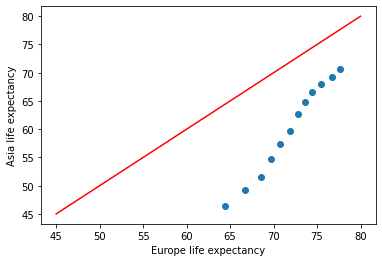

In [62]:
plt.scatter(life_exp['m_lifeExp']['Europe'],
            life_exp['m_lifeExp']['Asia'])
plt.plot([45, 80], [45, 80], 'r-')
plt.xlabel('Europe life expectancy')
plt.ylabel('Asia life expectancy')

### wide to long

- stacking (with indexes)

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-by-stacking-and-unstacking

- melt (with column names)

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-by-melt

#### stacking (with indexes)

In [63]:
life_exp = (gapminder.groupby(['continent', 'year'])
                    .agg(m_lifeExp = ('lifeExp', 'mean'))
                    .unstack('continent'))

In [64]:
life_exp

m_lifeExp                                         
continent     Africa  Americas       Asia     Europe  Oceania
year                                                         
1952       39.135500  53.27984  46.314394  64.408500  69.2550
1957       41.266346  55.96028  49.318544  66.703067  70.2950
1962       43.319442  58.39876  51.563223  68.539233  71.0850
1967       45.334538  60.41092  54.663640  69.737600  71.3100
1972       47.450942  62.39492  57.319269  70.775033  71.9100
1977       49.580423  64.39156  59.610556  71.937767  72.8550
1982       51.592865  66.22884  62.617939  72.806400  74.2900
1987       53.344788  68.09072  64.851182  73.642167  75.3200
1992       53.629577  69.56836  66.537212  74.440100  76.9450
1997       53.598269  71.15048  68.020515  75.505167  78.1900
2002       53.325231  72.42204  69.233879  76.700600  79.7400
2007       54.806038  73.60812  70.728485  77.648600  80.7195

In [65]:
# creates indexes
life_exp.stack()

m_lifeExp
year continent           
1952 Africa     39.135500
     Americas   53.279840
     Asia       46.314394
     Europe     64.408500
     Oceania    69.255000
1957 Africa     41.266346
     Americas   55.960280
     Asia       49.318544
     Europe     66.703067
     Oceania    70.295000
1962 Africa     43.319442
     Americas   58.398760
     Asia       51.563223
     Europe     68.539233
     Oceania    71.085000
1967 Africa     45.334538
     Americas   60.410920
     Asia       54.663640
     Europe     69.737600
     Oceania    71.310000
1972 Africa     47.450942
     Americas   62.394920
     Asia       57.319269
     Europe     70.775033
     Oceania    71.910000
1977 Africa     49.580423
     Americas   64.391560
     Asia       59.610556
     Europe     71.937767
     Oceania    72.855000
1982 Africa     51.592865
     Americas   66.228840
     Asia       62.617939
     Europe     72.806400
     Oceania    74.290000
1987 Africa     53.344788
     Americas   68.090720
     Asia       64.851182
     Europe     73.642167
     Oceania    75.320000
1992 Africa     53.629577
     Americas   69.568360
     Asia       66.537212
     Europe     74.440100
     Oceania    76.945000
1997 Africa     53.598269
     Americas   71.150480
     Asia       68.020515
     Europe     75.505167
     Oceania    78.190000
2002 Africa     53.325231
     Americas   72.422040
     Asia       69.233879
     Europe     76.700600
     Oceania    79.740000
2007 Africa     54.806038
     Americas   73.608120
     Asia       70.728485
     Europe     77.648600
     Oceania    80.719500

#### melting (column names)

In [66]:
life_exp = (gapminder.groupby(['continent', 'year'])
                    .agg(m_lifeExp = ('lifeExp', 'mean'))
                    .unstack('continent')['m_lifeExp'].reset_index())

In [67]:
life_exp

continent,year,Africa,Americas,Asia,Europe,Oceania
0,1952,39.135500,53.27984,46.314394,64.408500,69.2550
1,1957,41.266346,55.96028,49.318544,66.703067,70.2950
2,1962,43.319442,58.39876,51.563223,68.539233,71.0850
3,1967,45.334538,60.41092,54.663640,69.737600,71.3100
4,1972,47.450942,62.39492,57.319269,70.775033,71.9100
5,1977,49.580423,64.39156,59.610556,71.937767,72.8550
6,1982,51.592865,66.22884,62.617939,72.806400,74.2900
7,1987,53.344788,68.09072,64.851182,73.642167,75.3200
8,1992,53.629577,69.56836,66.537212,74.440100,76.9450
9,1997,53.598269,71.15048,68.020515,75.505167,78.1900


In [68]:
life_exp.melt(id_vars = ('year'),
              value_vars = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania'],
             var_name = 'continent',
             value_name = 'mean_life_expectancy')

,year,continent,mean_life_expectancy
0,1952,Africa,39.135500
1,1957,Africa,41.266346
2,1962,Africa,43.319442
3,1967,Africa,45.334538
4,1972,Africa,47.450942
5,1977,Africa,49.580423
6,1982,Africa,51.592865
7,1987,Africa,53.344788
8,1992,Africa,53.629577
9,1997,Africa,53.598269


reshaping:

with indexes: unstack and stack

with column names: pivot and melt

# Let's do something complicated together.

**Goal**: we want to know how life expectancy has changed with gdpPercapita over time, for the different continents.


### Complicated plot

First: let's make a plot of life expectancy as a function of gdpPerCapita, for each continent, for each year.  

So we want a years x continents subplot

and we want some nice labels.  

Perhaps we have size vary with country population?

label x, y, row, column

#### Complicated analysis

Let's figure out how life expectancy has changed over time with gdp per capita.

We want to know how the mean life expectancy, and the relationship with gdp per capita, has changed over time, for each continent.

